# Lab 1 - ARIMA+NN

1. (2 points) Apply ARIMA model for forecasting. Explain the choice of p,d,q paramters. Did you
notice anything strange?
2. (3 points) Implement LSTM architectures for the given dataset. Estimate its performance.
3. (3 points) Implement TSS architectures for the given dataset. Estimate its performance.
4. (2 points) Compare results of the algorithms.

In [1]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
train = np.load(join("data", "train.npy"))
test = np.load(join("data", "test.npy"))

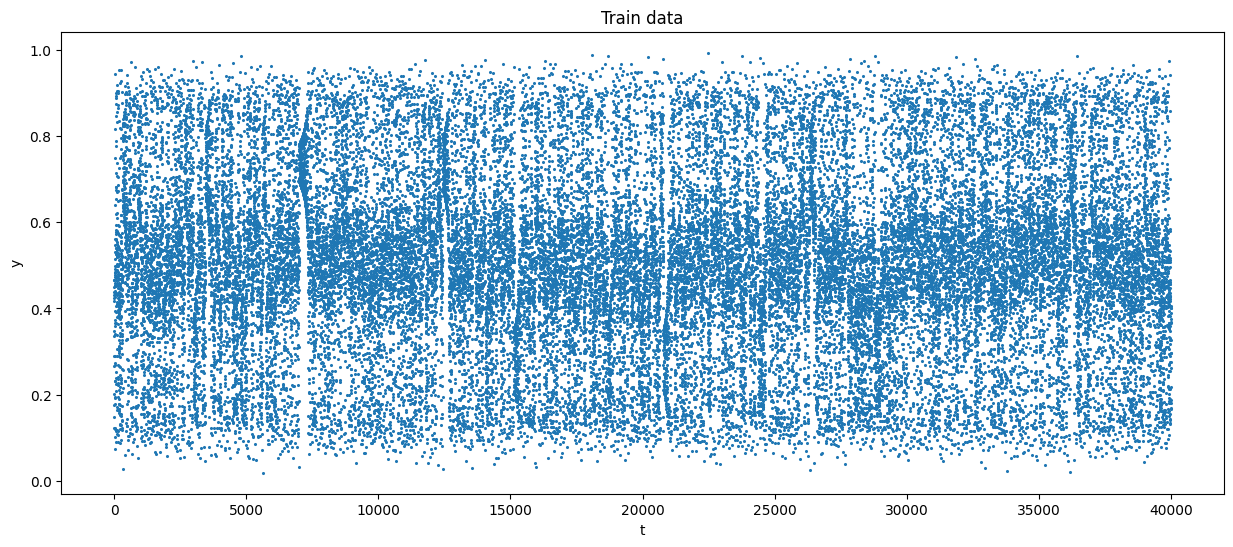

In [3]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(40_000), train, s=1.5)
plt.title("Train data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

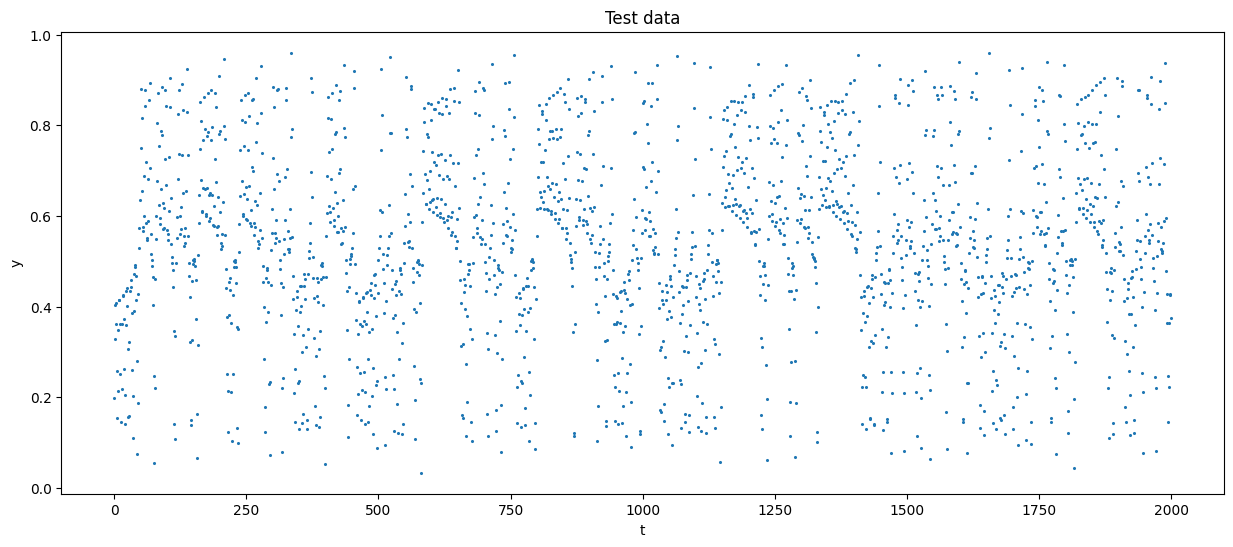

In [4]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(2_000), test, s=1.5)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

In [5]:
def acf(series: np.ndarray, k: int) -> float:
    mean = np.mean(series)
    return ((series[k:] - mean) * (series[:-k] - mean)).sum() / np.pow(series - mean, 2).sum()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 13098.60it/s]


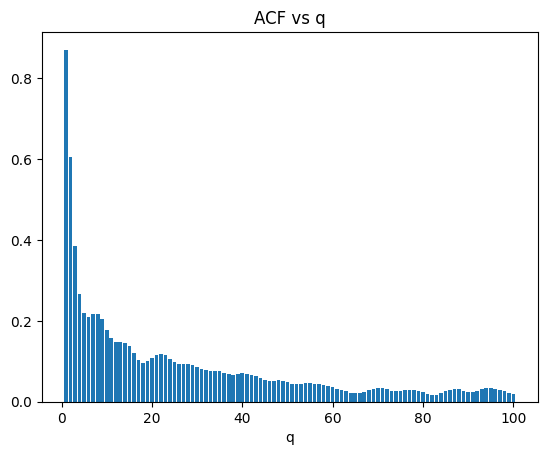

In [6]:
from tqdm import trange

k = 100

acf_data = [acf(train, i) for i in trange(1, k+1)]
plt.bar(np.arange(1, k + 1), acf_data[:k])
plt.title("ACF vs q")
plt.xlabel("q")
plt.show()

According to the graph `q` should be equal to 3

In [20]:
from numpy.lib.stride_tricks import sliding_window_view

class AR(BaseEstimator, RegressorMixin):
    def __init__(self, q: int, lr: float = 1e-1, max_iter: int = 1_000, tol: float = 1e-7, verbose: bool = False):
        self.weights_ = np.random.normal(size=(q,))
        self.bias_ = np.random.normal()
        self.q = q
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.verbose_ = verbose

    def fit(self, X):
        self.loss_hist_ = []
        for i in range(self.max_iter_):
            diffs = X[self.q:] - sliding_window_view(X[:-1], self.q) @ self.weights_ - self.bias_
            self.bias_ += self.lr_ * diffs.mean()
            self.weights_ += self.lr_ * (diffs @ sliding_window_view(X[:-1], self.q)) / diffs.shape[0]
            loss = (diffs**2).mean()
            self.loss_hist_.append(loss)
            if i != 0:
                if np.abs(loss - prev_loss) < self.tol_:
                    if self.verbose_:
                        print("Min tolerance reached!")
                    break
            else:
                if self.verbose_:
                    print(f"Initial loss: {loss:.4f}")
            prev_loss = loss
        if self.verbose_:
            print(f"Final loss: {loss:.4f}")
        return self

    def predict(self, X):
        return X[-self.q:] @ self.weights_ + self.bias_

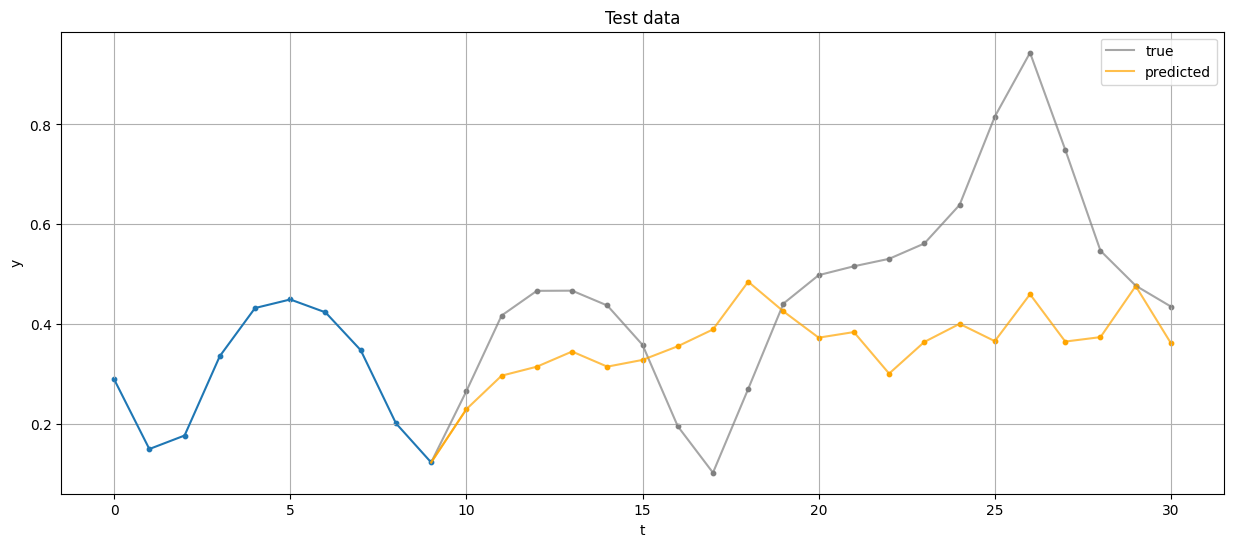

In [12]:
k = 30
p = 10

ar = AR(p).fit(train)
ar_preds = train[:p].copy()

for i in range(0, k - p + 1):
    pred = ar.predict(ar_preds)
    ar_preds = np.append(ar_preds, pred)

# ar_preds = np.array([ar.predict(train[:i + p]) for i in range(0, k - p + 1)])

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, p), train[:p], s=10)
plt.plot(np.arange(0, p), train[:p])
plt.scatter(np.arange(p, k+1), train[p:k+1], s=10, c="grey")
plt.plot(np.arange(p-1, k+1), train[p-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(p, k+1), ar_preds[p:k+1], s=10, c="orange")
plt.plot(np.arange(p-1, k+1), ar_preds[p-1:k+1], c="orange", alpha=.7, label="predicted")
plt.plot([p-1, p], ar_preds[p-1:p+1], c="orange", alpha=.7)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

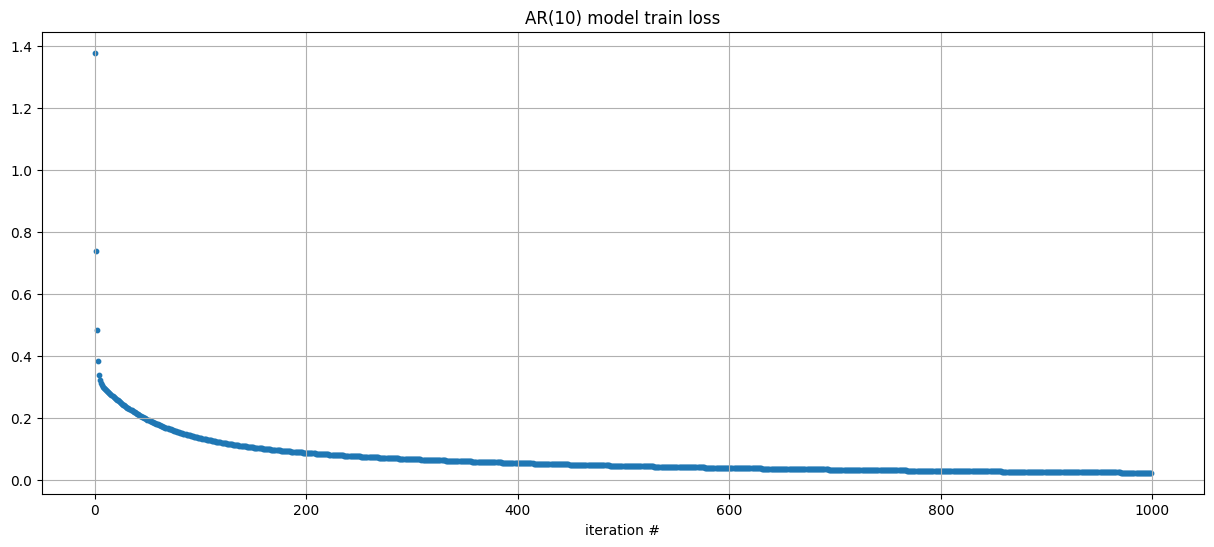

In [18]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, len(ar.loss_hist_)), ar.loss_hist_, s=10)
plt.title(f"AR({ar.q}) model train loss")
plt.xlabel("iteration #")
plt.grid()
plt.show()

In [21]:
def pacf(series: np.ndarray, q: int) -> float:
    linreg = AR(q).fit(series)
    return linreg.weights_[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:15<00:00,  1.26s/it]


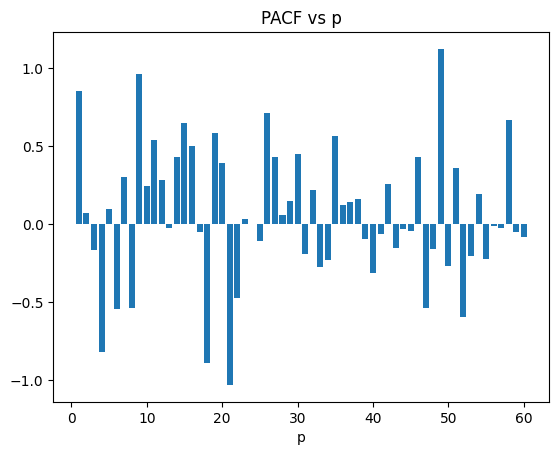

In [22]:
from tqdm import trange

k = 60
pacf_data = [pacf(train, i) for i in trange(1, k+1)]

plt.bar(np.arange(1, k+1), pacf_data[:k])
plt.title("PACF vs p")
plt.xlabel("p")
plt.show()

The PACF plot suggests that `p` should be equal to 17, since it experiences a sharp breakoff

In [ ]:
class ARIMA(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, q: int, d: int):
        self.value_weights_ = np.random.normal(size=(p,))
        self.error_weights_ = np.random.normal(size=(q,))
        self.bias_ = np.random.normal()

    def fit(self, X):

    def predict(self, X):